# Financial Time Series Analysis
# Modern Portfolio Theory

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import gridspec

from scipy.stats import lognorm, norm

In [2]:
correlations = pd.read_csv('../data/correlations.csv')
correlations.head()

,Asset1,Asset2,ML_Correlation,Pearson_Correlation
0,SAB.MC,BBVA.MC,0.727927,0.725490
1,SAB.MC,IAG.MC,0.423958,0.485032
2,SAB.MC,REP.MC,0.449955,0.490512
3,SAB.MC,MTS.MC,0.421958,0.461777
4,SAB.MC,MRL.MC,0.311969,0.392193


In [3]:
parameters = pd.read_csv('../data/returns_fit.csv')
parameters.head()

,Asset,loc,scale,se_loc,se_scale,p_value,ks_stat
0,SAB.MC,0.000537,0.018248,0.000385,0.000374,0.844981,0.011972
1,BBVA.MC,0.000777,0.014779,0.000394,0.000308,0.583355,0.015147
2,IAG.MC,0.000296,0.019202,0.000443,0.000417,0.422130,0.017165
3,REP.MC,0.000292,0.013568,0.000334,0.000280,0.360174,0.018048
4,MTS.MC,0.000000,0.020146,0.000459,0.000358,0.347118,0.018246


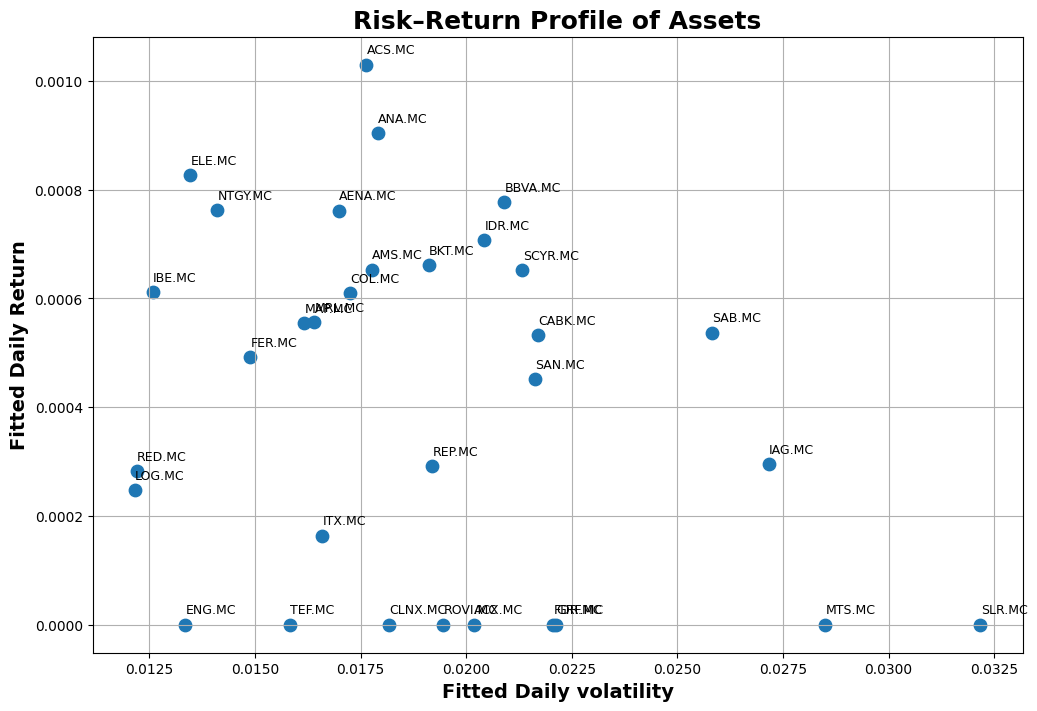

In [4]:
plt.figure(figsize=(12, 8))
plt.scatter( np.sqrt(2)*parameters['scale'],parameters['loc'], label = parameters['Asset'], s=80)
for i, row in parameters.iterrows():
    plt.text(np.sqrt(2)*row['scale'] + 0.00001, row['loc'] +0.00002, row['Asset'], fontsize=9)

plt.title("Risk–Return Profile of Assets", fontsize=18, fontweight='bold')
plt.xlabel("Fitted Daily volatility", fontsize=14, fontweight='bold')
plt.ylabel("Fitted Daily Return", fontsize=14, fontweight='bold')
plt.grid(True)

C:\Users\juanc\AppData\Local\Temp\ipykernel_35328\3632706940.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


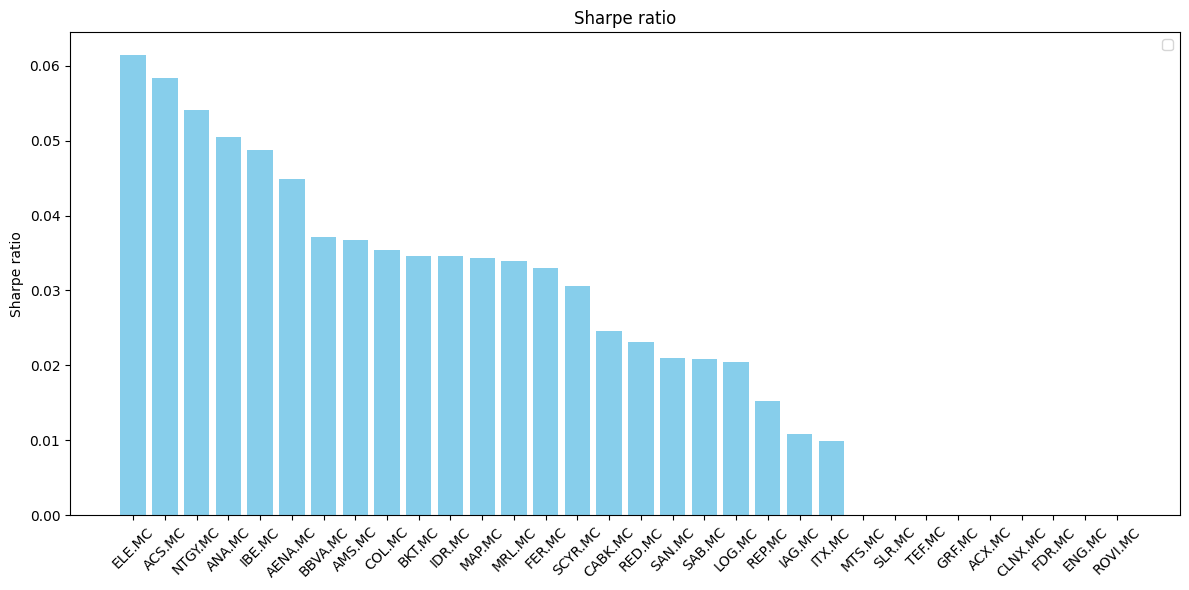

In [5]:
parameters['Sharpe'] = parameters['loc'] / (np.sqrt(2)*parameters['scale'])

parameters = parameters.sort_values(by='Sharpe', ascending=False)
plt.figure(figsize=(12, 6))
plt.bar(parameters['Asset'], parameters['Sharpe'], color='skyblue')
plt.xticks(rotation=45)
plt.ylabel('Sharpe ratio')
plt.title('Sharpe ratio')
plt.legend()
plt.tight_layout()
plt.show()

In [6]:
def Gradient_Component1(fraction, correlation, multiplier1, volatility, returns):
    gradient = np.zeros_like(volatility)
    num_assets = len(volatility)
    
    for i in range(num_assets):
        covariance_contribution = 2 * volatility[i] * np.sum(fraction * volatility * correlation[:, i])
        gradient[i] = covariance_contribution - multiplier1 * returns[i]

    return gradient
        
def Gradient_Component2(fraction, e_return, returns):
    return np.dot(fraction, returns) - e_return

def Volatility(fraction, volatility, correlation):
    total = 0.0
    for i in range(len(fraction)):
        for j in range(len(fraction)):
            total += fraction[i] * fraction[j] * volatility[i] * volatility[j] * correlation[i, j]
    return np.sqrt(max(total, 0))
    
def Gradient_descend_Optimization(portfolio, e_return, learning_rate=5000, tolerance=1e-8, max_iter=1000000):
    fit = pd.read_csv('../data/returns_fit.csv')
    fit = fit[fit['Asset'].isin(portfolio)].set_index('Asset')

    returns = fit.loc[portfolio]['loc'].to_numpy()
    volatility = np.sqrt(2) * fit.loc[portfolio]['scale'].to_numpy()

    correlation_raw = pd.read_csv('../data/correlations.csv')
    correlation_filtered = correlation_raw[
        correlation_raw['Asset1'].isin(portfolio) & 
        correlation_raw['Asset2'].isin(portfolio)
    ]
    correlation_matrix = correlation_filtered.pivot_table(index='Asset1', columns='Asset2', values='ML_Correlation')
    correlation_matrix = correlation_matrix.combine_first(correlation_matrix.T)
    all_assets = sorted(portfolio)
    correlation_matrix = correlation_matrix.reindex(index=all_assets, columns=all_assets).fillna(0.0)
    np.fill_diagonal(correlation_matrix.values, 1.0)
    correlation = correlation_matrix.to_numpy()

    parameters = np.zeros(len(portfolio)) / len(portfolio)

    fraction  = np.exp( parameters)
    fraction  = fraction / np.sum(fraction)
    
    multiplier1 = 2 * volatility[0] * np.sum(fraction * volatility * correlation[:, 0])/returns[0]

    vol = 1e9
    for _ in range(max_iter):
        fraction  = np.exp( parameters)
        fraction  = fraction / np.sum(fraction)
        
        grad = Gradient_Component1(fraction, correlation, multiplier1, volatility, returns)

        J = np.diag(fraction) - np.outer(fraction, fraction)

        grad = J.T @ grad
        parameters -= learning_rate * grad
    
        prev_multiplier1 = multiplier1

        multiplier1 -= learning_rate * (np.dot(fraction, returns) - e_return)
        
        new_vol = Volatility(fraction, volatility, correlation)
        if (abs(new_vol - vol) +   abs(multiplier1 - prev_multiplier1) ) < tolerance:
            break
        vol = new_vol
    return fraction, vol

In [7]:
portfolio = ['ELE.MC', 'ACS.MC','ANA.MC' ,'AENA.MC' , 'BBVA.MC']

def compute_efficient_frontier(portfolio, num_points=50):

    fit = pd.read_csv('../data/returns_fit.csv')
    fit = fit[fit['Asset'].isin(portfolio)].set_index('Asset')
    volatilities1 = np.sqrt(2) * fit.loc[portfolio]['scale'].to_numpy()
    asset_returns = fit.loc[portfolio]['loc'].to_numpy()
    
    min_ret, max_ret = asset_returns.min(), asset_returns.max()

    target_returns = np.linspace(min_ret, max_ret, num_points)

    volatilities = []
    realized_returns = []
    allocations = []

    for e_return in target_returns:
        if e_return == min_ret or e_return == max_ret:
            idx = np.where(asset_returns == e_return)[0][0]
            
            realized_returns.append(e_return)
            fraction = np.zeros(len(portfolio))
            fraction[idx] = 1
            vol = volatilities1[idx]
            volatilities.append(vol)
            allocations.append(fraction)
            
        else:
            try:
                weights, vol = Gradient_descend_Optimization(portfolio, e_return)
                portfolio_return = np.dot(weights, asset_returns)
        
                volatilities.append(vol)
                realized_returns.append(portfolio_return)
                allocations.append(weights)
            except Exception as e:
                print(f"Failed for target {e_return:.4f}: {e}")
                continue


    return np.array(volatilities), np.array(realized_returns), np.array(allocations)

vols, rets, allocs = compute_efficient_frontier(portfolio)

Max sharpe ratio portfolio (Sharpe ratio 0.07452063323894866):
['ELE.MC', 'ACS.MC', 'ANA.MC', 'AENA.MC', 'BBVA.MC']
[0.41013097 0.30921482 0.22907226 0.04944525 0.00213669]
Main volatility portfolio:
['ELE.MC', 'ACS.MC', 'ANA.MC', 'AENA.MC', 'BBVA.MC']
[0.45322439 0.16212456 0.17195052 0.14443267 0.06826786]


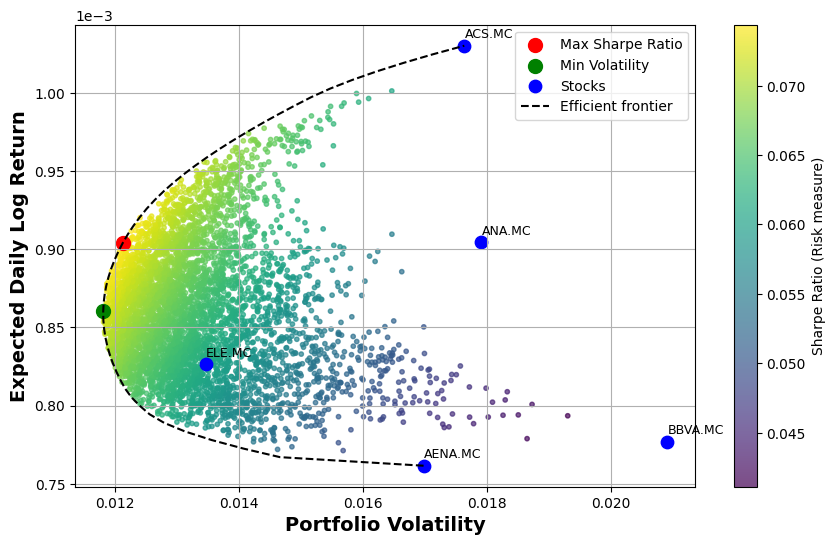

In [8]:
filtered_params = parameters[parameters['Asset'].isin(portfolio)]
n_assets = len(portfolio)
expected_returns = filtered_params['loc'].to_numpy()
volatility = np.sqrt(2) *filtered_params['scale'].to_numpy()

correlation_raw = pd.read_csv('../data/correlations.csv')
correlation_filtered = correlation_raw[correlation_raw['Asset1'].isin(portfolio) & correlation_raw['Asset2'].isin(portfolio)]
correlation_matrix = correlation_filtered.pivot_table(index='Asset1', columns='Asset2', values='ML_Correlation')
correlation_matrix = correlation_matrix.combine_first(correlation_matrix.T)
all_assets = sorted(portfolio)
correlation_matrix = correlation_matrix.reindex(index=all_assets, columns=all_assets).fillna(0.0)
np.fill_diagonal(correlation_matrix.values, 1.0)
correlation = correlation_matrix.to_numpy()

n_portfolios = 5000
all_weights = np.random.dirichlet(np.ones(n_assets), size=n_portfolios)
portfolio_returns = all_weights @ expected_returns
cov_matrix = np.outer(volatility, volatility) * correlation
portfolio_vols = np.sqrt(np.einsum('ij,jk,ik->i', all_weights, cov_matrix, all_weights))

sharpe_ratios1 = portfolio_returns / portfolio_vols
max_sharpe_idx = np.argmax(sharpe_ratios1)

sharpe_ratios = rets/vols
max_sharpe_idx = np.argmax(sharpe_ratios)
max_sharpe_vol = vols[max_sharpe_idx]
max_sharpe_ret = rets[max_sharpe_idx]

mix_vol_idx = np.argmin(vols)
mix_vol_vol = vols[mix_vol_idx]
mix_vol_ret = rets[mix_vol_idx]

print(f'Max sharpe ratio portfolio (Sharpe ratio {sharpe_ratios[max_sharpe_idx]}):')
print(portfolio)
print(allocs[max_sharpe_idx])

print('Main volatility portfolio:')
print(portfolio)
print(allocs[mix_vol_idx])

plt.figure(figsize=(10, 6))
for i, row in filtered_params.iterrows():
    plt.text(  np.sqrt(2) * row['scale'] + 0.00001, row['loc'] + 0.000005,  row['Asset'], fontsize=9)
scatter = plt.scatter(portfolio_vols, portfolio_returns, c=sharpe_ratios1, cmap='viridis', s=10, alpha=0.7)

cbar = plt.colorbar(scatter)
cbar.set_label('Sharpe Ratio (Risk measure)')
plt.scatter(max_sharpe_vol, max_sharpe_ret, color='red', s=100, label='Max Sharpe Ratio')
plt.scatter(mix_vol_vol, mix_vol_ret, color='green', s=100, label='Min Volatility')

plt.scatter(  np.sqrt(2) * filtered_params['scale'], filtered_params['loc'], color = 'blue', s=80, label = 'Stocks')
plt.plot(vols, rets, linestyle='--', color='black', label='Efficient frontier') 
plt.xlabel('Portfolio Volatility', fontsize = 14, fontweight = 'bold')
plt.ylabel('Expected Daily Log Return', fontsize = 14, fontweight = 'bold')

plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.grid(True)
plt.legend()
plt.show()

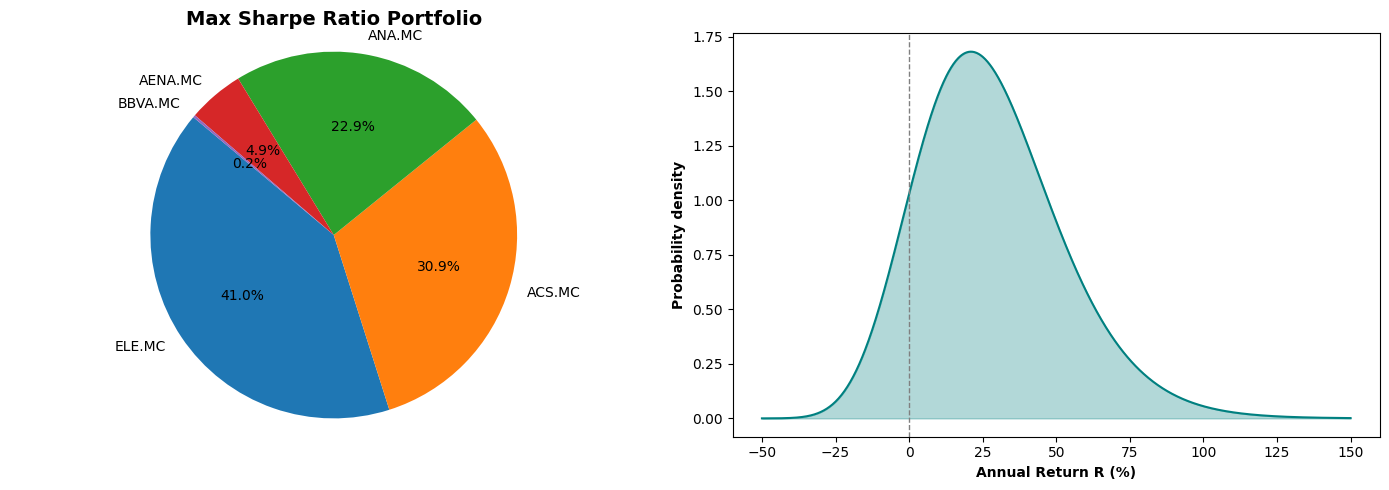

In [9]:
max_sharpe_allocs = allocs[max_sharpe_idx]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].pie(max_sharpe_allocs, labels=portfolio, autopct='%1.1f%%', startangle=140)
axes[0].set_title('Max Sharpe Ratio Portfolio', fontsize=14, fontweight='bold')
axes[0].axis('equal')

r = 100 * np.linspace(-0.5, 1.5, 1000) 
mu = 252 * max_sharpe_ret
sigma = np.sqrt(252) * max_sharpe_vol
x = r / 100 + 1

pdf_r = lognorm.pdf(x, s=sigma, scale=np.exp(mu))

axes[1].plot(r, pdf_r, color='teal')
axes[1].fill_between(r, pdf_r, alpha=0.3, color='teal')

axes[1].set_xlabel('Annual Return R (%)', fontweight='bold')
axes[1].set_ylabel('Probability density', fontweight='bold')
axes[1].axvline(0, color='gray', linestyle='--', linewidth=1)


plt.tight_layout()
plt.show()

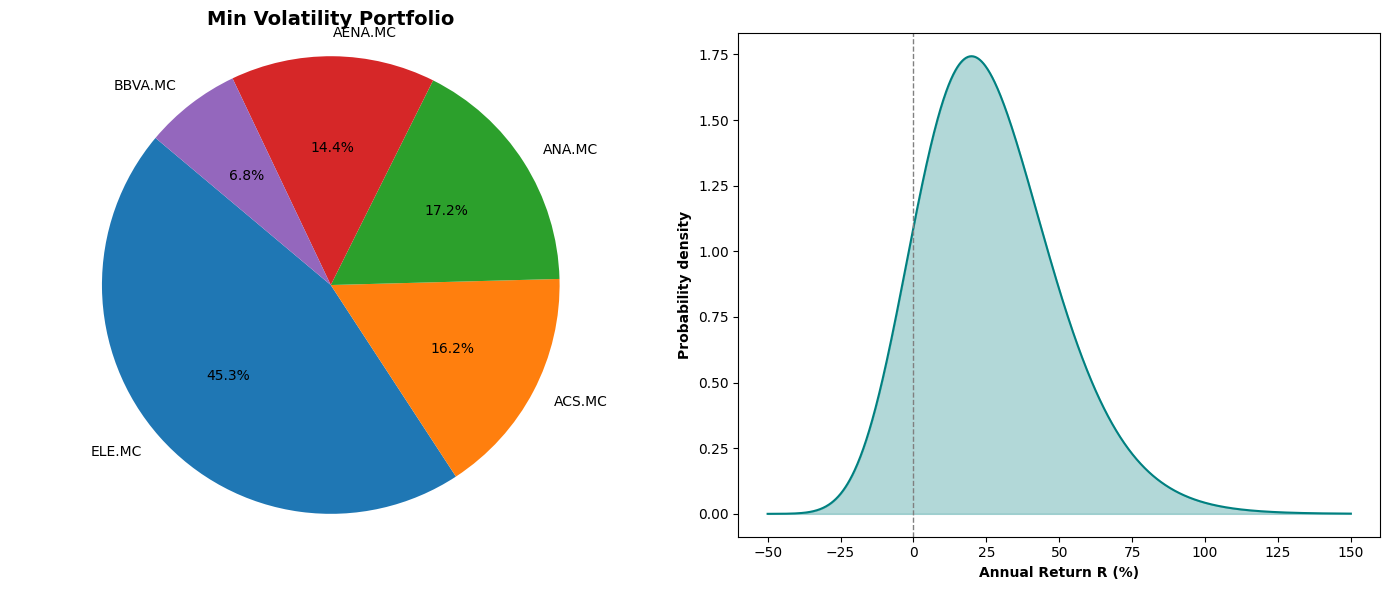

In [10]:
min_vol_allocs = allocs[mix_vol_idx]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].pie(min_vol_allocs, labels=portfolio, autopct='%1.1f%%', startangle=140)
axes[0].set_title('Min Volatility Portfolio', fontsize=14, fontweight='bold')
axes[0].axis('equal')

r = 100 * np.linspace(-0.5, 1.5, 1000)
mu = 252 * mix_vol_ret
sigma = np.sqrt(252) * mix_vol_vol
x = r / 100 + 1

pdf_r = lognorm.pdf(x, s=sigma, scale=np.exp(mu))

axes[1].plot(r, pdf_r, color='teal')
axes[1].fill_between(r, pdf_r, alpha=0.3, color='teal')

axes[1].set_xlabel('Annual Return R (%)', fontweight='bold')
axes[1].set_ylabel('Probability density', fontweight='bold')
axes[1].axvline(0, color='gray', linestyle='--', linewidth=1)

plt.tight_layout()
plt.show()

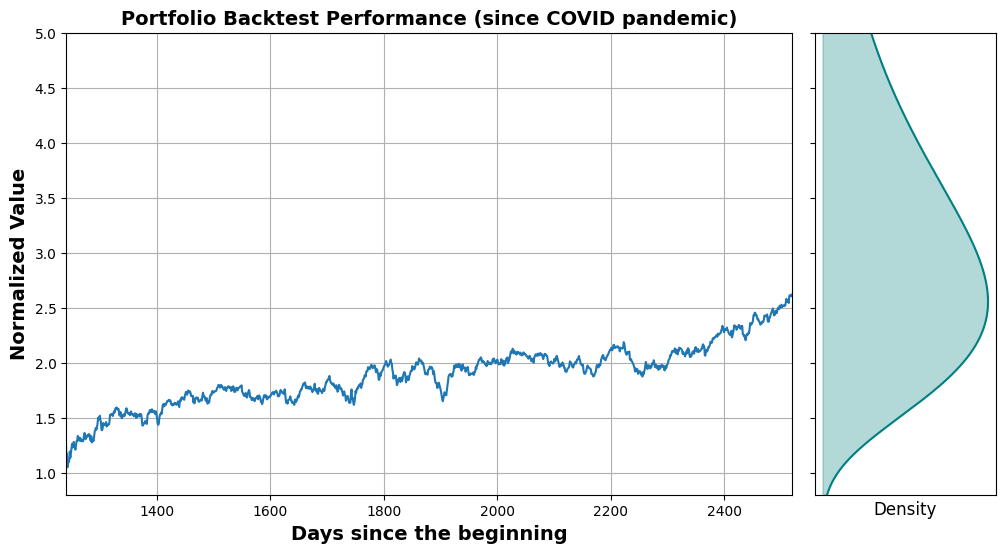

In [13]:
historical_data = pd.read_csv('../data/financial_data.csv')
columns_to_select = [f'Close_{asset}' for asset in portfolio]
selected_data = historical_data[columns_to_select]
normalized_data = selected_data / selected_data.iloc[0]
portfolio_returns = (normalized_data * max_sharpe_allocs).sum(axis=1)


fig = plt.figure(figsize=(12, 6))
gs = gridspec.GridSpec(1, 2, width_ratios=[4, 1], wspace=0.05)

mu = 4.92*252 * max_sharpe_ret     
sigma = np.sqrt(4.92*252) * max_sharpe_vol
y = np.linspace(0.8, 10, 1000)
pdf = lognorm.pdf(y, s=sigma, scale=np.exp(mu))


ax0 = plt.subplot(gs[0])
ax0.plot(portfolio_returns, label='Portfolio Performance')
ax0.set_title('Portfolio Backtest Performance (since COVID pandemic)', fontsize=14, fontweight='bold')
ax0.set_ylabel('Normalized Value', fontsize=14, fontweight='bold')
ax0.set_xlabel('Days since the beginning', fontsize=14, fontweight='bold')
ax0.grid(True)


ax1 = plt.subplot(gs[1], sharey=ax0)
ax1.plot(pdf, y, color='teal')
ax1.fill_betweenx(y, 0, pdf, color='teal', alpha=0.3)
ax1.set_xlabel('Density', fontsize=12)
ax1.set_xticks([])
ax1.yaxis.set_tick_params(labelleft=False)
ax0.set_ylim(0.8, 5)
ax1.set_ylim(0.8, 5)
ax0.set_xlim(252*4.92, 252*10)
plt.show()

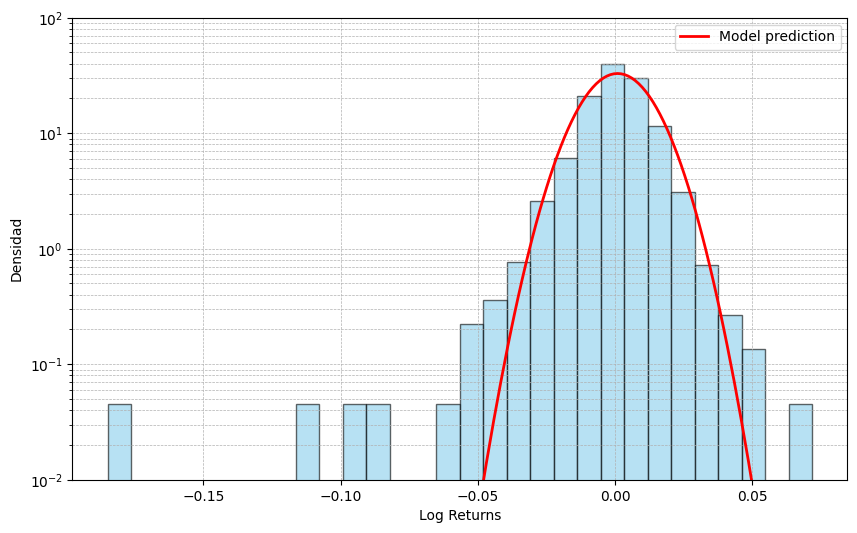

In [12]:
portfolio_log_returns = np.log(portfolio_returns /portfolio_returns.shift(1))

loc =  max_sharpe_ret
scale =  max_sharpe_vol

fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(portfolio_log_returns, bins=30, density=True, color='skyblue',
        edgecolor='black', alpha=0.6)
x = np.linspace(portfolio_log_returns.min(), portfolio_log_returns.max(), 200)
y = norm.pdf(x, loc, scale)

ax.plot(x, y, 'r-', lw=2, label='Model prediction')
ax.set_xlabel("Log Returns")
ax.set_ylabel("Densidad")
ax.legend()
ax.set_yscale("log")
ax.set_ylim(1e-2, 1e2)
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.show()